In [39]:
#Based on features provided for the mobile we need to classify the price range
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
data = pd.read_csv("Cellphone.csv")
data.head(10)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
5,1859,0,0.5,1,3,0,22,0.7,164,1,...,1004,1654,1067,17,1,10,1,0,0,1
6,1821,0,1.7,0,4,1,10,0.8,139,8,...,381,1018,3220,13,8,18,1,0,1,3
7,1954,0,0.5,1,0,0,24,0.8,187,4,...,512,1149,700,16,3,5,1,1,1,0
8,1445,1,0.5,0,0,0,53,0.7,174,7,...,386,836,1099,17,1,20,1,0,0,0
9,509,1,0.6,1,2,1,9,0.1,93,5,...,1137,1224,513,19,10,12,1,0,0,0


In [16]:
data['price_range'].value_counts()

3    500
2    500
1    500
0    500
Name: price_range, dtype: int64

In [20]:
#data set is clean, so no pre-processing
#Vanilla Model - Model usage in origional state
#Dropping y value
x = data.drop('price_range',axis=1)
y = data['price_range']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=100)

In [27]:
svm = SVC()
svm.fit(x_train, y_train)
score = svm.score(x_test,y_test)

#y_predict = svm.predict(x_test)
print(score)
#sns.heatmap(confusion_matrix(y_test,y_predict),annot = True)
#if score is greater than 85 its a good score

1.0


In [26]:
score = svm.score(x_train,y_train)
print(score)

0.9573333333333334


In [31]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(x.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(x_train, y_train)


importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)


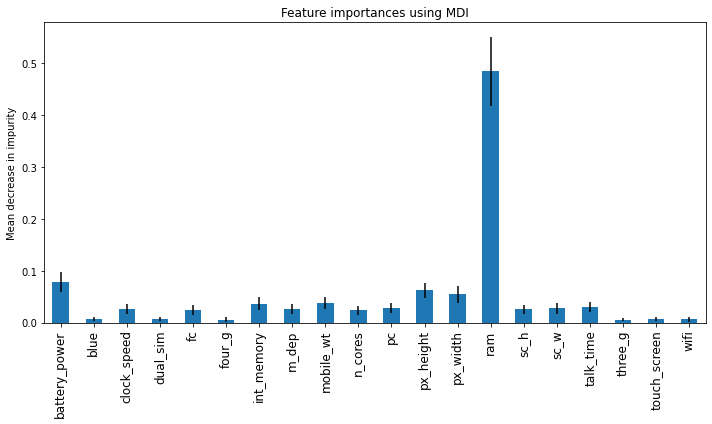

In [33]:
#import pandas as pd
x_tick_labels = x.columns
forest_importances = pd.Series(importances, index=x_tick_labels)

fig, ax = plt.subplots()
fig.set_size_inches(10,6)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(x_tick_labels,rotation = 'vertical',fontsize = 12)
fig.tight_layout()




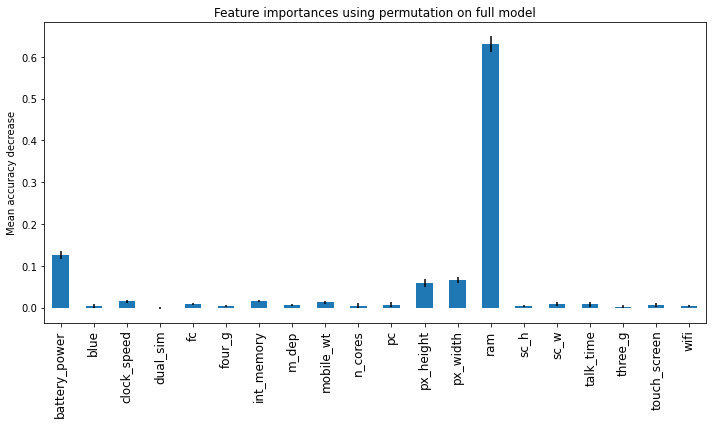

In [34]:
from sklearn.inspection import permutation_importance

#start_time = time.time()
result = permutation_importance(
    forest, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
#elapsed_time = time.time() - start_time
#print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
ax.set_xticklabels(x_tick_labels,rotation = 'vertical',fontsize = 12)
fig.tight_layout()
plt.show()


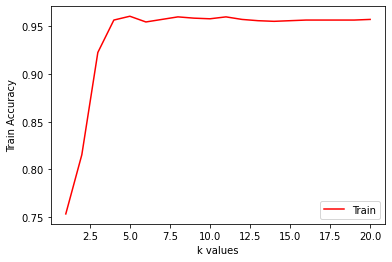

In [43]:
#use k-best
#Based on ANNOVA, F-SCORE classification

from sklearn.feature_selection import SelectKBest, f_classif
train_accuracy = []
k = np.arange(1,21)


#Select the top most features in the order and then check the accuracy
for i in k:
    select = SelectKBest(f_classif,k=i) 
    x_train_new = select.fit_transform(x_train,y_train)
    svm.fit(x_train_new,y_train)
    train_accuracy.append(svm.score(x_train_new,y_train))

plt.plot(k,train_accuracy,color='red', label = 'Train')
plt.xlabel('k values')
plt.ylabel('Train Accuracy')
plt.legend()
plt.show()




In [46]:
select_top = SelectKBest(f_classif, k=5)
x_train_new = select_top.fit_transform(x_train,y_train)
x_test_new = select_top.fit_transform(x_test,y_test)

print("The Top Train Features", x_train.columns.values[select_top.get_support()])
print("The Top Test Features", x_test.columns.values[select_top.get_support()])



The Top Train Features ['battery_power' 'dual_sim' 'px_height' 'px_width' 'ram']
The Top Test Features ['battery_power' 'dual_sim' 'px_height' 'px_width' 'ram']


In [47]:
from sklearn.model_selection import GridSearchCV
c = [1.0, 0.25, 0.5, 0.75]
kernels = ['linear', 'rbf']
gammas = ['auto', 0.01, 0.001, 1] #1/n_feature

svm = SVC()

grid_svm = GridSearchCV(estimator = svm, param_grid = dict(kernel = kernels, C = c, gamma = gammas), cv = 5)
grid_svm.fit(x_train_new, y_train)
print('The best hyperparamters: ', grid_svm.best_params_)


The best hyperparamters:  {'C': 1.0, 'gamma': 'auto', 'kernel': 'linear'}


In [ ]:
#hyper parameter tuning
#HW
#Randaomsearch CV
#Manual Search - Parameters with balance score bet train and test and high

In [48]:
svc_model = SVC(C=0.5, gamma='auto', kernel= 'linear')
svc_model.fit(x_train_new,y_train)
print("Train accuracy ", svc_model.score(x_train_new,y_train))
print("Test accuracy ", svc_model.score(x_test_new,y_test))

Train accuracy  0.98
Test accuracy  0.866


<AxesSubplot:>

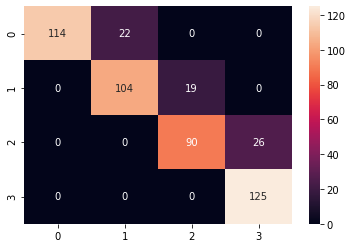

In [52]:
y_predict = svc_model.predict(x_test_new)
sns.heatmap(confusion_matrix(y_test,y_predict),fmt= 'g',annot = True)

In [ ]:
#AUC, ROC Curve
#False Positive Rate
#True Positive Rate
#Y-axis is TPR - True Positive Rate
#X-axis is FPR - False Positive Rate

In [1]:
def plot_multiclass_roc(clf, X_test,y_test,n_classes, figsize = (17,6)):
  y_score = clf.decision_function(X_test)

  #Structures 
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  #calculate dummies for y
  y_test_dummies = pd.get_dummies(y_test,drop_first = False).values
  for i in range(n_classes):
    fpr[i],tpr[i], _ = roc_curve(y_test_dummies[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])

  fig, ax = plt.subplots(figsize = figsize)
  ax.plot([0,1],[1,0],'k--')
  ax.set_xlim([0.0,1.0])
  ax.set_ylim([0.0,1.05])
  ax.set_xlabel("False Positive Rate")
  ax.set_ylabel("True Positive Rate")
  ax.set_title("ROC Plot")
  for i in range(n_classes):
    ax.plot(fpr[i],tpr[i],label = 'ROC curve (area = %0.2f for label %i)'%(roc_auc[i],i))
  ax.legend(loc = 'best')
  ax.grid(alpha = .4)
  #sns.despine()
  plt.show()



